<a href="https://colab.research.google.com/github/msrepo/ml-mscise-2023/blob/master/catsvsdogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train a Deep Feedforward Network using a deep learning framework
- use as much of the framework as possible (avoid writing code from scratch if it is available in the framework)



###Download dataset



In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O cats_and_dogs_filtered.zip

--2023-01-21 13:21:06--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  20.8MB/s    in 3.8s    

2023-01-21 13:21:10 (17.2 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
!unzip -o cats_and_dogs_filtered.zip 

###imports

In [ ]:
!pip install pytorch_lightning
!pip install wandb

In [2]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict
from torchvision.transforms import Compose,Resize,ToTensor,Normalize
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
%matplotlib inline

###utility functions

In [4]:
# {'cats':0,'dogs':1} -> {0:'cats',1:'dogs'}
def index_to_class(class_to_idx:Dict):
  idx_to_class = {}
  for k,v in class_to_idx.items():
    idx_to_class[v] = k
  return idx_to_class


In [5]:
def plot_image_labels(images:torch.Tensor,labels:torch.Tensor):
  NUM_IMAGES_DISPLAY = len(labels)
  IMAGE_RES = 14
  fig,ax = plt.subplots(1,NUM_IMAGES_DISPLAY,figsize=(IMAGE_RES,NUM_IMAGES_DISPLAY*IMAGE_RES))
  for i,sample_img,sample_class_idx in zip(range(NUM_IMAGES_DISPLAY),images.numpy(),labels.numpy()):
    sample_img = np.transpose(sample_img,[1,2,0]) # tensors are loaded in CHW, matplotlib requires HWC
    idx_to_class = index_to_class(training_dataset.class_to_idx)
    ax[i].imshow(sample_img)
    ax[i].set_title(f'{idx_to_class[sample_class_idx]}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
  plt.show()

###build dataset

#####define transforms

In [6]:
# images are of different size
# deep feedforward network require the input to be of predefined size
IMAGE_SIZE = 96
image_transform = Compose([
    ToTensor(),
    Resize(size=(IMAGE_SIZE,IMAGE_SIZE)),
    Normalize(mean=(0,0,0),std=(1,1,1))
])

In [7]:
# https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
training_dataset = ImageFolder(root = '/content/cats_and_dogs_filtered/train',transform=image_transform)
validation_dataset = ImageFolder(root='/content/cats_and_dogs_filtered/validation',transform=image_transform)

training_dataloader = DataLoader(training_dataset,batch_size=8,shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=8,shuffle=False)

print(f'Training data {len(training_dataset)} samples')
print(f'Validation data {len(training_dataset)} samples')
print(f'Image classes {training_dataset.classes}')
print(f'Image classes index {training_dataset.class_to_idx}')

Training data 2000 samples
Validation data 2000 samples
Image classes ['cats', 'dogs']
Image classes index {'cats': 0, 'dogs': 1}


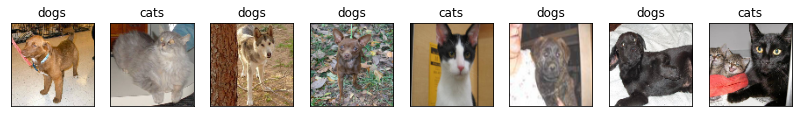

In [8]:
images, class_idxs = next(iter(training_dataloader))
plot_image_labels(images,class_idxs)

###build model

In [12]:
class CatvsDogExperiment(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = torch.nn.Sequential(
        torch.nn.Linear(in_features=3*IMAGE_SIZE*IMAGE_SIZE, out_features=2000), # input layer
        torch.nn.ReLU(), # max(0,wTx+b),
        torch.nn.Linear(in_features=2000, out_features = 64), # hidden layer
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=64,out_features=1) # output_layer
    )
    self.loss_function = torch.nn.BCEWithLogitsLoss()
  
  def training_step(self,batch,batch_idx):
    # y* ,y : the learning rate defines how aggressively we try to correct the discrepancy between prediction and the desired output
    x,y = batch
    y_pred = self.model(x.reshape(-1,3*IMAGE_SIZE*IMAGE_SIZE))
    loss =  self.loss_function(y_pred, y.unsqueeze(1).float())
    self.log('train_loss',loss,on_step=True,on_epoch=True,prog_bar=True)
    return loss
  
  def validation_step(self,batch,batch_idx):
    x,y = batch
    y_pred = self.model(x.reshape(-1,3*IMAGE_SIZE*IMAGE_SIZE))
    val_loss = self.loss_function(y_pred,y.unsqueeze(1).float())
    self.log('val_loss',val_loss,on_step=True,on_epoch=True,prog_bar=True)
    return val_loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.model.parameters(),lr=0.01) # this optimizer will optimize theta, choose learning rate

In [ ]:
wandb_logger = WandbLogger(project='cats_vs_dogs')
trainer = pl.Trainer(max_epochs=200,log_every_n_steps=1,accelerator='gpu',devices=1,logger=wandb_logger)
catvdog_experiment = CatvsDogExperiment()
trainer.fit(model=catvdog_experiment,train_dataloaders= training_dataloader,val_dataloaders=validation_dataloader)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | model         | Sequential        | 55.4 M
1 | loss_function | BCEWithLogitsLoss | 0     
----------------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]